<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/EXP/%5BE_09%5Dreview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E09] 영화리뷰 감성분석

## 루브릭
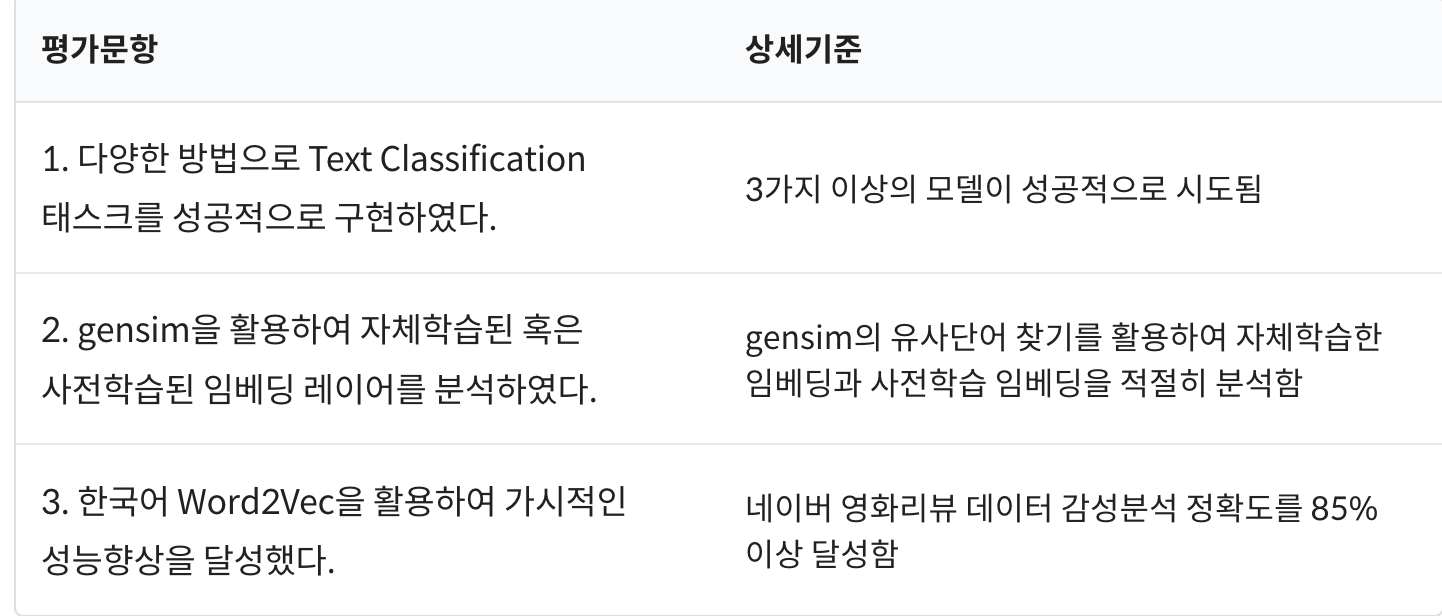

In [ ]:
!pip install konlpy
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash
import pandas
import konlpy
import gensim
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import Constant

from gensim.models.keyedvectors import Word2VecKeyedVectors
import gensim
from gensim.models import KeyedVectors

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 540 kB/s 
     |████████████████████████████████| 453 kB 51.7 MB/s 
--2022-06-07 12:32:29--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-06-07 12:32:29--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca481f8a5f979713b8d0c6cb711.dl.dropboxusercontent.com/cd/0/get/BmzHornVhKzYwvdyo8iDMXPmoASKqwMMwK6WnuvvxjhpUV5YL055IxZrIR21JJjXeMhC_HN5IWTHh9SbmJLprX1HV-aYqmN6byCOU

## 데이터 로더 구성

In [ ]:
3# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/Aiffel/data/review/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Aiffel/data/review/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() 
    counter = Counter(words) #알파벳 마다 카운팅
    counter = counter.most_common(10000-4) #정렬해서 가장 개수가 많은 // 10000-4는 vocab_size - special token
    vocab = ['<PAD>', '<BOS>', '<UNK>', 'UNSED'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
# function, data 확인
print(get_decoded_sentence(X_train[1], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  0


In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [ ]:
# Train, val data 분리
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2022)

## 모델설정
- LSTM
- Conv2d
- GMP(Global MaxPooling1D)

In [ ]:
def eval_visual(model,epoch):
  model = model
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])
  history = model.fit(partial_x_train,partial_y_train, epochs=epoch,batch_size = 32, validation_data = (x_val,y_val),verbose=1)
  result = model.evaluate(X_test,y_test,verbose=2)


  history_dict = history.history

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  
  # Loss
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
  # Accuracy
  plt.clf()
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  
  return history

In [ ]:
class LSTMModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 128
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.lstm = keras.layers.LSTM(128)
        self.dense = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense(x)
        
        return x

class Conv1DModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 64
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.conv1 = keras.layers.Conv1D(64, 7, activation='relu')
        self.maxp = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(64, 7, activation='relu')
        self.gmaxp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.gmaxp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

class GMPModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 64
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.gmp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x




In [ ]:
lstm_model = LSTMModel()
conv1d_model = Conv1DModel()
gmp_model = GMPModel()

Epoch 1/10
3427/3427 [==============================] - 34s 8ms/step - loss: 0.3705 - accuracy: 0.8350 - val_loss: 0.3258 - val_accuracy: 0.8583
Epoch 2/10
3427/3427 [==============================] - 24s 7ms/step - loss: 0.2853 - accuracy: 0.8795 - val_loss: 0.3283 - val_accuracy: 0.8620
Epoch 3/10
3427/3427 [==============================] - 28s 8ms/step - loss: 0.2403 - accuracy: 0.8995 - val_loss: 0.3297 - val_accuracy: 0.8643
Epoch 4/10
3427/3427 [==============================] - 27s 8ms/step - loss: 0.1986 - accuracy: 0.9190 - val_loss: 0.3511 - val_accuracy: 0.8602
Epoch 5/10
3427/3427 [==============================] - 25s 7ms/step - loss: 0.1608 - accuracy: 0.9358 - val_loss: 0.3999 - val_accuracy: 0.8528
Epoch 6/10
3427/3427 [==============================] - 25s 7ms/step - loss: 0.1265 - accuracy: 0.9500 - val_loss: 0.4926 - val_accuracy: 0.8539
Epoch 7/10
3427/3427 [==============================] - 24s 7ms/step - loss: 0.1000 - accuracy: 0.9612 - val_loss: 0.5311 - val_ac

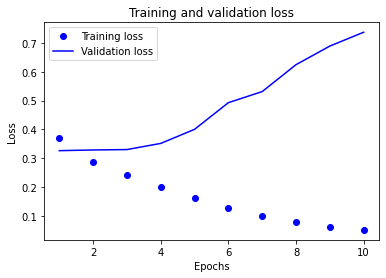

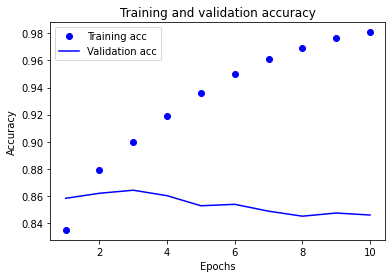

In [ ]:
lstm_history = eval_visual(lstm_model, 10)

Epoch 1/10
3427/3427 [==============================] - 25s 5ms/step - loss: 0.3670 - accuracy: 0.8335 - val_loss: 0.3220 - val_accuracy: 0.8598
Epoch 2/10
3427/3427 [==============================] - 18s 5ms/step - loss: 0.2588 - accuracy: 0.8925 - val_loss: 0.3356 - val_accuracy: 0.8590
Epoch 3/10
3427/3427 [==============================] - 17s 5ms/step - loss: 0.1755 - accuracy: 0.9313 - val_loss: 0.4105 - val_accuracy: 0.8553
Epoch 4/10
3427/3427 [==============================] - 17s 5ms/step - loss: 0.1113 - accuracy: 0.9582 - val_loss: 0.4732 - val_accuracy: 0.8479
Epoch 5/10
3427/3427 [==============================] - 18s 5ms/step - loss: 0.0769 - accuracy: 0.9717 - val_loss: 0.6008 - val_accuracy: 0.8432
Epoch 6/10
3427/3427 [==============================] - 18s 5ms/step - loss: 0.0584 - accuracy: 0.9782 - val_loss: 0.7606 - val_accuracy: 0.8432
Epoch 7/10
3427/3427 [==============================] - 18s 5ms/step - loss: 0.0458 - accuracy: 0.9829 - val_loss: 0.7703 - val_ac

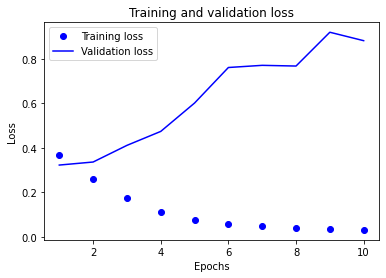

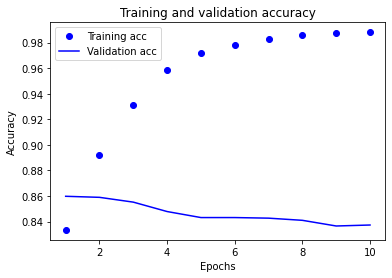

In [ ]:
conv1d_history = eval_visual(conv1d_model, 10)

Epoch 1/10
3427/3427 [==============================] - 15s 4ms/step - loss: 0.3922 - accuracy: 0.8243 - val_loss: 0.3498 - val_accuracy: 0.8472
Epoch 2/10
3427/3427 [==============================] - 14s 4ms/step - loss: 0.3030 - accuracy: 0.8721 - val_loss: 0.3455 - val_accuracy: 0.8514
Epoch 3/10
3427/3427 [==============================] - 14s 4ms/step - loss: 0.2594 - accuracy: 0.8949 - val_loss: 0.3538 - val_accuracy: 0.8515
Epoch 4/10
3427/3427 [==============================] - 14s 4ms/step - loss: 0.2215 - accuracy: 0.9126 - val_loss: 0.3734 - val_accuracy: 0.8486
Epoch 5/10
3427/3427 [==============================] - 13s 4ms/step - loss: 0.1882 - accuracy: 0.9273 - val_loss: 0.4070 - val_accuracy: 0.8475
Epoch 6/10
3427/3427 [==============================] - 14s 4ms/step - loss: 0.1586 - accuracy: 0.9402 - val_loss: 0.4407 - val_accuracy: 0.8410
Epoch 7/10
3427/3427 [==============================] - 14s 4ms/step - loss: 0.1323 - accuracy: 0.9511 - val_loss: 0.5097 - val_ac

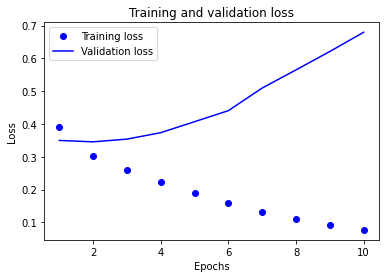

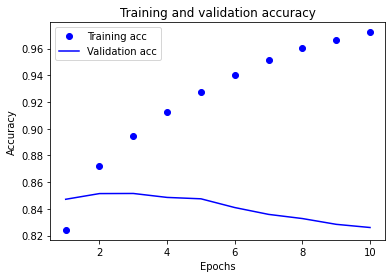

In [ ]:
gmp_history = eval_visual(gmp_model, 10)

## Embedding layer 분석

In [48]:
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/Aiffel/data/review/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.10899768, -0.00049913,  0.18021896, -0.03579926,  0.02076344,
       -0.16527888,  0.09479106,  0.08761722,  0.0730187 , -0.12741114,
       -0.11956592, -0.01124218, -0.1069957 , -0.34471917, -0.0306012 ,
       -0.15740429,  0.27656305,  0.06795379, -0.18967184, -0.24944335,
        0.22533052, -0.20730321,  0.21458879, -0.2709403 ,  0.17299038,
       -0.18881378,  0.02328995, -0.0078871 , -0.05721532, -0.0154452 ,
       -0.06322812,  0.0310347 ,  0.18394205, -0.03501288,  0.00578087,
        0.14916435,  0.1272927 ,  0.07878128,  0.08726495,  0.00790407,
        0.01654059, -0.12111794, -0.06103293,  0.14267589,  0.05753722,
       -0.13962726, -0.25655764, -0.06520752, -0.36126947,  0.06883789,
        0.13515365,  0.18116318, -0.20565963,  0.07256857,  0.03073052,
        0.0036278 ,  0.20436724,  0.03424742, -0.11797094,  0.17633714,
        0.2555139 , -0.07643225, -0.1892808 ,  0.06114815,  0.15426932,
        0.12013018,  0.04104202, -0.06703741, -0.13761607,  0.00

In [49]:
# lstm model을 통하여 만든 vector "감동"과 비슷한 단어들
word_vectors.similar_by_word("감동")

[('최고', 0.8188834190368652),
 ('캬', 0.8155387043952942),
 ('바치', 0.8050375580787659),
 ('감탄', 0.8017533421516418),
 ('막스', 0.7947715520858765),
 ('아름다움', 0.78556227684021),
 ('쵝오', 0.7786079049110413),
 ('원조', 0.7769086956977844),
 ('깨알', 0.77476966381073),
 ('꿀꿀', 0.7743855714797974)]

In [50]:
# lstm model을 통하여 만든 vector "실망"과 비슷한 단어들
word_vectors.similar_by_word("실망")

[('지루', 0.8618790507316589),
 ('착오', 0.8571276664733887),
 ('거품', 0.8502789735794067),
 ('천박', 0.8486789464950562),
 ('글쎄요', 0.8441925644874573),
 ('정극', 0.8438808917999268),
 ('삽질', 0.8437669277191162),
 ('ㅗ', 0.837487518787384),
 ('용두사미', 0.8325482606887817),
 ('실패', 0.8312220573425293)]

In [51]:
word_vectors.similar_by_word("감사")

[('남음', 0.8016272783279419),
 ('던져', 0.7981764078140259),
 ('즐거웠', 0.7977132797241211),
 ('타란티노', 0.7900714874267578),
 ('생각나', 0.7875317931175232),
 ('와우', 0.7830453515052795),
 ('극대', 0.7804269194602966),
 ('신자', 0.7799351811408997),
 ('작살', 0.7781556844711304),
 ('엄연히', 0.7778303623199463)]

In [52]:
word_vectors.similar_by_word("사랑")

[('시즌', 0.8562953472137451),
 ('로즈', 0.8232452869415283),
 ('진실', 0.819764256477356),
 ('시네마', 0.8186584711074829),
 ('생각나', 0.8175933957099915),
 ('고조', 0.8129733800888062),
 ('인생', 0.812888503074646),
 ('제공', 0.8103160262107849),
 ('감탄', 0.8025059700012207),
 ('재발견', 0.8017748594284058)]

In [53]:
word_vectors.similar_by_word("짝사랑")

[('이렇', 0.7055680751800537),
 ('변태', 0.7039281129837036),
 ('때려치', 0.6874216198921204),
 ('할린', 0.6711106896400452),
 ('컴', 0.6701787114143372),
 ('드럽', 0.6697065830230713),
 ('거지', 0.6627572774887085),
 ('디워', 0.6487463116645813),
 ('걸릴', 0.6476292610168457),
 ('비명', 0.6450086832046509)]

In [54]:
word_vectors.similar_by_word("헤어짐")

[('게라도', 0.8655487895011902),
 ('향하', 0.8521713018417358),
 ('더구나', 0.8471956253051758),
 ('셀', 0.833568274974823),
 ('잘라서', 0.83281409740448),
 ('혼돈', 0.8315557241439819),
 ('신세경', 0.8304411172866821),
 ('바람둥이', 0.8259702920913696),
 ('선전', 0.8259592056274414),
 ('저러', 0.825369656085968)]

In [55]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/Aiffel/data/review/conv1d_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.24832064, -0.10547528, -0.11003189,  0.13450581,  0.01164132,
        0.10254951, -0.02149501,  0.00969722, -0.15110187,  0.03713202,
        0.2048989 , -0.10525607, -0.00613756, -0.16037075,  0.20287809,
        0.17653096, -0.28918126,  0.07342222,  0.10263763,  0.03572748,
       -0.07785004, -0.11383633, -0.08285153,  0.18418166, -0.02093788,
       -0.08458636, -0.02681689, -0.15530616,  0.11150554,  0.1549519 ,
       -0.30570054,  0.20981629,  0.08558245,  0.05418737,  0.02833133,
        0.10748492, -0.2344847 , -0.08066301, -0.02403099, -0.35203603,
        0.07902907,  0.11012691, -0.25758192, -0.1088216 , -0.36169815,
       -0.07435159, -0.03249793,  0.31484762,  0.2364454 , -0.13211092,
       -0.02217034,  0.03822054, -0.21060655, -0.02098373,  0.17266646,
       -0.06737463,  0.1167464 ,  0.04665808,  0.01346516,  0.07742935,
        0.10271714, -0.1834462 , -0.08276404,  0.25764492], dtype=float32)

In [56]:
word_vectors.similar_by_word("감동")

[('디테일', 0.7391109466552734),
 ('굉장', 0.7121243476867676),
 ('즐겁', 0.6866132616996765),
 ('감격', 0.6835017204284668),
 ('보석', 0.6784101724624634),
 ('롤러코스터', 0.6758694052696228),
 ('느낍니다', 0.6692283153533936),
 ('싯', 0.6613398790359497),
 ('바치', 0.6555132269859314),
 ('막힌다', 0.6523120999336243)]

In [57]:
word_vectors.similar_by_word("실망")

[('낭패', 0.8496971130371094),
 ('편파', 0.8465907573699951),
 ('꼭두각시', 0.8388749957084656),
 ('역겨웠', 0.834867000579834),
 ('단조', 0.8208702802658081),
 ('엉성', 0.812926173210144),
 ('시끄럽', 0.8100885152816772),
 ('만드세요', 0.8066842555999756),
 ('인내력', 0.8045369982719421),
 ('돌렸', 0.8030411601066589)]

In [58]:
word_vectors.similar_by_word("감사")

[('감명깊', 0.6113449335098267),
 ('부시', 0.6029412150382996),
 ('수준급', 0.5782996416091919),
 ('의외', 0.5750230550765991),
 ('박력', 0.5698434114456177),
 ('사로잡', 0.5672380328178406),
 ('설레였', 0.5662809014320374),
 ('드러낸', 0.5658246278762817),
 ('수상', 0.5647352933883667),
 ('올려야', 0.5597595572471619)]

In [59]:
word_vectors.similar_by_word("사랑")

[('귓가', 0.7383108139038086),
 ('진진', 0.7299139499664307),
 ('반했', 0.7212681770324707),
 ('오오', 0.7186511158943176),
 ('케이온', 0.7185465097427368),
 ('따스', 0.7168359160423279),
 ('bbbb', 0.7127615809440613),
 ('누군가', 0.7124496698379517),
 ('뭉클', 0.7109270691871643),
 ('바치', 0.7101185321807861)]

In [60]:
word_vectors.similar_by_word("짝사랑")

[('논리', 0.6567586660385132),
 ('려는지', 0.6565761566162109),
 ('거린', 0.6483006477355957),
 ('패턴', 0.6168683171272278),
 ('할껄', 0.616534411907196),
 ('바뀐', 0.6165130734443665),
 ('유치찬란', 0.6140973567962646),
 ('디워', 0.6139984130859375),
 ('고갈', 0.6130867600440979),
 ('아녀', 0.6115860342979431)]

In [61]:
word_vectors.similar_by_word("헤어짐")

[('매체', 0.6285229325294495),
 ('사투', 0.6206017136573792),
 ('마술', 0.6114881038665771),
 ('소품', 0.6088286638259888),
 ('인칭', 0.5834041833877563),
 ('교감', 0.5792089700698853),
 ('작전', 0.5790493488311768),
 ('꾸미', 0.5677721500396729),
 ('갔다온', 0.5600075721740723),
 ('미치광이', 0.5543726682662964)]

In [62]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/Aiffel/data/review/GMP_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.22590987,  0.21714805, -0.06782287, -0.1622958 , -0.15573537,
       -0.14489776,  0.14067549, -0.0975398 , -0.04884597, -0.12772541,
        0.03235235, -0.0465726 , -0.03810928,  0.01013383, -0.14868987,
       -0.04674827, -0.21660721, -0.17980348,  0.14103056, -0.09953222,
       -0.03859894,  0.19077043,  0.17508341,  0.00552542, -0.16554184,
       -0.16237575, -0.08827166,  0.02644399, -0.14068636,  0.0117811 ,
       -0.06866395, -0.03708519, -0.12452418, -0.18470244, -0.16632007,
       -0.0949541 ,  0.1358534 , -0.04159652, -0.24327528, -0.16122717,
        0.17392014, -0.15795252,  0.08152359, -0.16981243,  0.1205947 ,
       -0.14622632, -0.12992314,  0.01817477,  0.11864288, -0.06065469,
        0.10880788,  0.15981875,  0.28644258,  0.07640254, -0.03208401,
        0.19590263,  0.1432748 , -0.10615206,  0.18843666, -0.12471303,
       -0.14305858,  0.23255014, -0.21953595, -0.02108711], dtype=float32)

In [63]:
word_vectors.similar_by_word("감동")

[('추억', 0.7356986999511719),
 ('어릴', 0.7234895825386047),
 ('순수', 0.7130270004272461),
 ('손예진', 0.7019044160842896),
 ('영광', 0.6973364353179932),
 ('기억', 0.6940402388572693),
 ('동시', 0.6885124444961548),
 ('멋진', 0.6838306188583374),
 ('현', 0.6826604008674622),
 ('또', 0.6783616542816162)]

In [64]:
word_vectors.similar_by_word("실망")

[('안습', 0.7925915718078613),
 ('지겹', 0.7868850827217102),
 ('뭔', 0.7854680418968201),
 ('시시', 0.7675418853759766),
 ('어휴', 0.7649368047714233),
 ('그만', 0.7644239068031311),
 ('비운', 0.7626042366027832),
 ('아무것', 0.7512991428375244),
 ('잤', 0.7505859136581421),
 ('고어', 0.7482403516769409)]

In [65]:
word_vectors.similar_by_word("감사")

[('딩크', 0.5473849177360535),
 ('흘리', 0.539485514163971),
 ('차이', 0.5367773771286011),
 ('바꿔', 0.535765528678894),
 ('베이더', 0.5292888879776001),
 ('a', 0.5095186829566956),
 ('!!!!!!', 0.5006150007247925),
 ('게리온', 0.49748072028160095),
 ('긴말', 0.49523234367370605),
 ('면', 0.49261850118637085)]

In [66]:
word_vectors.similar_by_word("사랑")

[('현', 0.6955825686454773),
 ('ㅠㅠㅠ', 0.6746081113815308),
 ('또', 0.6705124378204346),
 ('신', 0.6652050018310547),
 ('멋진', 0.6603289842605591),
 ('눈물', 0.6570771336555481),
 ('괜찮', 0.6539568901062012),
 ('뛰어나', 0.6528210639953613),
 ('코난', 0.6525781750679016),
 ('년', 0.6518067717552185)]

In [67]:
word_vectors.similar_by_word("짝사랑")

[('공군', 0.6215040683746338),
 ('방송국', 0.5506718158721924),
 ('희생양', 0.521538257598877),
 ('황', 0.48646241426467896),
 ('렛', 0.4743392765522003),
 ('스마트', 0.4676186442375183),
 ('아무리', 0.4657077491283417),
 ('정성', 0.4618327021598816),
 ('안타까워', 0.4583667516708374),
 ('나선', 0.454390287399292)]

In [68]:
word_vectors.similar_by_word("헤어짐")

[('돌려서', 0.41831332445144653),
 ('cctv', 0.4149879813194275),
 ('간단', 0.40861260890960693),
 ('덴젤', 0.3996317386627197),
 ('무섭', 0.39945346117019653),
 ('는다고', 0.39645689725875854),
 ('김대희', 0.38533180952072144),
 ('..?', 0.38079023361206055),
 ('운적', 0.3798721432685852),
 ('연속극', 0.3787473738193512)]

In [69]:
#pip install gensim==3.8.1
word2vec_path = '/content/drive/MyDrive/Aiffel/data/review/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [70]:
word2vec.similar_by_word("감동")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [71]:
word2vec.similar_by_word("실망")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('당황', 0.7591220140457153),
 ('경악', 0.6881837248802185),
 ('분개', 0.6751235723495483),
 ('분노', 0.6750859022140503),
 ('격분', 0.647419810295105),
 ('감동', 0.6267645955085754),
 ('감탄', 0.6222271919250488),
 ('원망', 0.6156655550003052),
 ('조심', 0.6145114898681641),
 ('감복', 0.6109203696250916)]

In [72]:
word2vec.similar_by_word("감사")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감사원', 0.5044692158699036),
 ('서무', 0.4843790531158447),
 ('도지사', 0.4654870331287384),
 ('결재', 0.46455061435699463),
 ('회계', 0.4616725444793701),
 ('자문', 0.4596004784107208),
 ('출석', 0.44367003440856934),
 ('심의', 0.44340527057647705),
 ('협의', 0.44103771448135376),
 ('청문', 0.43760183453559875)]

In [73]:
word2vec.similar_by_word("사랑")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [74]:
word2vec.similar_by_word("짝사랑")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('그리워하', 0.6691212058067322),
 ('행세', 0.6303051710128784),
 ('상냥', 0.6274478435516357),
 ('쫓아다니', 0.6179249882698059),
 ('무서워하', 0.6156602501869202),
 ('떠올리', 0.6144543290138245),
 ('소심', 0.6107739210128784),
 ('미워하', 0.6010301113128662),
 ('좋아하', 0.5997301340103149),
 ('무뚝뚝', 0.5936835408210754)]

In [77]:
word2vec.similar_by_word("이별")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('헤어지', 0.6900225877761841),
 ('슬픔', 0.6873862147331238),
 ('추억', 0.6457439661026001),
 ('슬프', 0.6412862539291382),
 ('재회', 0.6345380544662476),
 ('사랑', 0.6334798336029053),
 ('첫사랑', 0.6128619909286499),
 ('고독', 0.6117805242538452),
 ('절망', 0.5997450947761536),
 ('작별', 0.5857374668121338)]

In [76]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
class LSTMModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.lstm = keras.layers.LSTM(64)
        self.dense1 = keras.layers.Dense(256, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

class Conv1DModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.conv1 = keras.layers.Conv1D(64, 7, activation='relu')
        self.maxp = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(64, 7, activation='relu')
        self.gmaxp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.gmaxp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

class GMPModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.gmp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [ ]:
lstm_model_ko = LSTMModel_ko(embedding_matrix)
conv1d_model_ko = Conv1DModel_ko(embedding_matrix)
gmp_model_ko = GMPModel_ko(embedding_matrix)

Epoch 1/10
3427/3427 [==============================] - 26s 7ms/step - loss: 0.3901 - accuracy: 0.8218 - val_loss: 0.3328 - val_accuracy: 0.8554
Epoch 2/10
3427/3427 [==============================] - 24s 7ms/step - loss: 0.2929 - accuracy: 0.8762 - val_loss: 0.3187 - val_accuracy: 0.8635
Epoch 3/10
3427/3427 [==============================] - 27s 8ms/step - loss: 0.2497 - accuracy: 0.8968 - val_loss: 0.3363 - val_accuracy: 0.8669
Epoch 4/10
3427/3427 [==============================] - 26s 8ms/step - loss: 0.2102 - accuracy: 0.9143 - val_loss: 0.3412 - val_accuracy: 0.8632
Epoch 5/10
3427/3427 [==============================] - 24s 7ms/step - loss: 0.1723 - accuracy: 0.9306 - val_loss: 0.3755 - val_accuracy: 0.8599
Epoch 6/10
3427/3427 [==============================] - 24s 7ms/step - loss: 0.1393 - accuracy: 0.9455 - val_loss: 0.4345 - val_accuracy: 0.8609
Epoch 7/10
3427/3427 [==============================] - 26s 8ms/step - loss: 0.1106 - accuracy: 0.9561 - val_loss: 0.4858 - val_ac

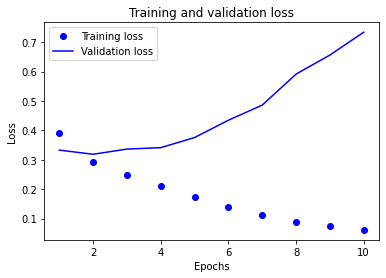

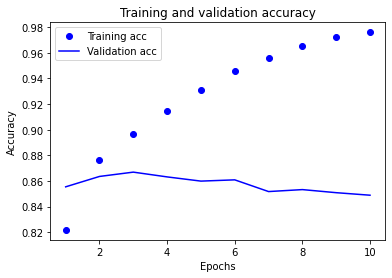

In [ ]:
lstm_ko_history = eval_visual(lstm_model_ko, 10)

Epoch 1/8
3427/3427 [==============================] - 21s 6ms/step - loss: 0.4272 - accuracy: 0.7983 - val_loss: 0.3676 - val_accuracy: 0.8348
Epoch 2/8
3427/3427 [==============================] - 20s 6ms/step - loss: 0.3142 - accuracy: 0.8649 - val_loss: 0.3445 - val_accuracy: 0.8505
Epoch 3/8
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2663 - accuracy: 0.8889 - val_loss: 0.3579 - val_accuracy: 0.8466
Epoch 4/8
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2201 - accuracy: 0.9101 - val_loss: 0.3822 - val_accuracy: 0.8505
Epoch 5/8
3427/3427 [==============================] - 20s 6ms/step - loss: 0.1739 - accuracy: 0.9303 - val_loss: 0.4347 - val_accuracy: 0.8466
Epoch 6/8
3427/3427 [==============================] - 21s 6ms/step - loss: 0.1368 - accuracy: 0.9459 - val_loss: 0.4973 - val_accuracy: 0.8470
Epoch 7/8
3427/3427 [==============================] - 20s 6ms/step - loss: 0.1059 - accuracy: 0.9594 - val_loss: 0.5728 - val_accuracy:

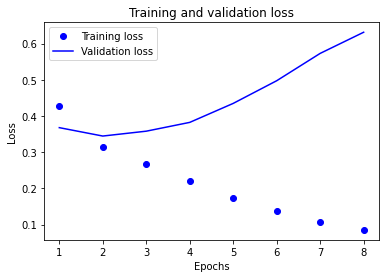

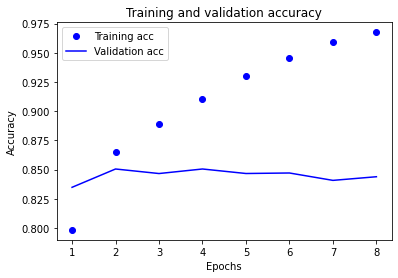

In [ ]:
#.8505 이후로 오히려 val loss 상승
conv1d_ko_history = eval_visual(conv1d_model_ko, 8)

Epoch 1/8
3427/3427 [==============================] - 16s 4ms/step - loss: 0.5490 - accuracy: 0.7070 - val_loss: 0.4596 - val_accuracy: 0.7833
Epoch 2/8
3427/3427 [==============================] - 16s 5ms/step - loss: 0.4180 - accuracy: 0.8079 - val_loss: 0.4128 - val_accuracy: 0.8130
Epoch 3/8
3427/3427 [==============================] - 16s 5ms/step - loss: 0.3669 - accuracy: 0.8387 - val_loss: 0.3942 - val_accuracy: 0.8224
Epoch 4/8
3427/3427 [==============================] - 15s 4ms/step - loss: 0.3318 - accuracy: 0.8569 - val_loss: 0.3876 - val_accuracy: 0.8286
Epoch 5/8
3427/3427 [==============================] - 16s 5ms/step - loss: 0.3036 - accuracy: 0.8719 - val_loss: 0.3874 - val_accuracy: 0.8313
Epoch 6/8
3427/3427 [==============================] - 15s 4ms/step - loss: 0.2790 - accuracy: 0.8848 - val_loss: 0.3893 - val_accuracy: 0.8323
Epoch 7/8
3427/3427 [==============================] - 15s 4ms/step - loss: 0.2560 - accuracy: 0.8968 - val_loss: 0.4082 - val_accuracy:

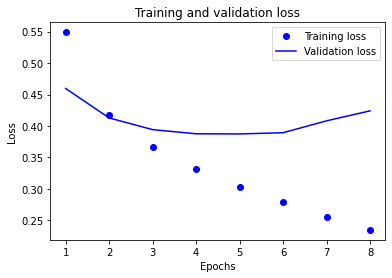

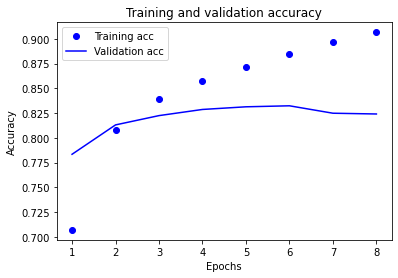

In [ ]:
gmp_ko_history = eval_visual(gmp_model_ko, 8)

# 회고록
* Embedding layer 분석 (내가 뽑아본 애매했던 단어들)
  - LSTM  
  감동 : 원조,꿀꿀,바치  
  실망 : 거품, 글쎄요, 정극  
  감사 : 남음,던져,타란티노,작살,엄연히  
  사랑 : 감탄,재발견,제공  
  짝사랑 : 이렇,비명,거지,드럽,컴,할린,변태 (유사도 최대 .7)   
  헤어짐 : 게라도,향하,더구나,셀,잘라서,혼돈,신세경,선전,저러 (바람둥이가 그나마 잘 뽑아낸 단어)  
  - Conv2d  
  감동 : 싯,바치,막힌다,롤러코스터  
  실망 : 단조,만드세요,돌렸  
  감사 : 부시,드러낸  
  사랑 : 진진,케이온,바치  
  짝사랑 : 논리,려는지,거린,패턴,디워,아녀  
  헤어짐 : 매체,사투,마술,소품,인칭,교감,작전,꾸미,갔다온,미치광이  
  - MaxPooling1D  
  감동 : 손예진,동시,현  
  실망 : 잤,고어  
  감사: 딩크,흘리,차이,바꿔,베이더,a,게리온,긴말,면  
  사랑 : 현,또,뛰어나,코난,년  
  짝사랑 : 공군,방송국,황,렛,스마트,나선  
  헤어짐: 돌려서,cctv,간단,덴젤,무섭,는다고,김대희,..?,운적

  - word2vec
  감동 ; 실망  
  실망 : 감탄,감복  
  감사 : 감사원,서무,도지사,결재,회계, 등등 (감정의 감사가 아닌 감사기관의 감사로 생각한듯)  
  사랑 : 이별  
  짝사랑 : 무서워하  
  이별 : 사랑


  결론: 동음이의어,다의어인 단어들은 어떻게 유사도를 책정하는지 궁금해짐. 전반적으로 어떤 분석에 사용하기에는 애매했던 부분이 많았던거 같고 word2vec에서는 성공률이 높아 보였지만, 감사와 같이 분석자가 원하는 의도대로 보여주지 않는 단어들에 대한 추가적처리가 필요해보였다.


